Telescope - Jupiter Notebook

A notebook version of the rayoptics telescope python file. 

A file to explore the telescopes layout by adjusting mirror sizing and placement.

In [29]:
%matplotlib inline
# use standard rayoptics environment
from rayoptics.environment import *
from rayoptics.optical.opticalmodel import *
from rayoptics.util import misc_math

import numpy as np
import matplotlib.pyplot as plt

isdark = False


# Build the optical model
opm = OpticalModel()
sm = opm['seq_model']
osp = opm['optical_spec']
pm = opm['parax_model']
em = opm['ele_model']
pt = opm['part_tree']

opm.system_spec.title = 'Telescope'
opm.system_spec.dimensions = 'mm'



In [30]:
# Specify aperture, field, and wavelengths
osp['wvls'] = WvlSpec([(940.0, 1.0)], ref_wl=0)
osp['pupil'] = PupilSpec(osp, key=['object', 'epd'], value=2.)
osp['fov'] = FieldSpec(osp, key=('object', 'angle'), value=1.,
                    #    flds=[1., .5, .25, -.25, -.5, -1.],
                       flds=[1., -1.],
                       is_relative=True)

Settings for the mirrors size, shape, and spacing. These can be edited for another telescope or adjusted to explore relationships between components. 

In [31]:
# Setup info for mirrors
## Primary
mirrorPrimaryFocalLength = 1000 # units = mm
mirrorPrimaryDiameter = 120 # units = mm
mirrorPrimaryThickness = 30 # units = mm
r = mirrorPrimaryFocalLength * 2
## Air gap between primary and secondary
distancePrimarySecondary = 760 # units = mm
## Secondary
mirrorSecondaryDiameter = 30 # units = mm
mirrorSecondaryThickness = 3 # units = mm
mirrorSecondaryAngle = 45 # units = degrees

Functions for rotating the secondary mirror. This block was found at https://github.com/mjhoptics/ray-optics/discussions/165 Does not require editing. 

In [32]:
## addMirro() and shiftr() from https://github.com/mjhoptics/ray-optics/discussions/165
# Used for secondary mirrors rotation
def shiftr(euler, vec, noz=False):
    rom = misc_math.euler2rot3d(euler)
    # rom = Rotation.from_euler('xyz', euler, degrees=True).as_matrix()
    xlat = np.dot(rom, vec)
    if noz: xlat[2] = 0
    return xlat

def addMirror(sd, m, euler_design=[-45,0,0], euler_clocking=[0,0,0], euler_off=[0,0,0], shift=[0,0,0], clock_after=False):
    if not clock_after:
        opm.add_dummy_plane()
        sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('decenter')
        sm.ifcs[sm.cur_surface].decenter.euler = np.array(euler_clocking)
    opm.add_dummy_plane()
    sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('decenter')
    sm.ifcs[sm.cur_surface].decenter.euler = np.array(euler_design)
    opm.add_mirror(sd=sd)
    mir1 = sm.cur_surface
    sm.ifcs[mir1].decenter = srf.DecenterData('dec and return')
    sm.ifcs[mir1].decenter.euler = np.array(euler_off)
    sm.ifcs[mir1].decenter.dec = shiftr(np.array(euler_design), np.array(shift))
    opm.add_dummy_plane()
    sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('decenter')
    sm.ifcs[sm.cur_surface].decenter.euler = np.array(euler_design)
    if clock_after:
        opm.add_dummy_plane()
        sm.ifcs[sm.cur_surface].decenter = srf.DecenterData('decenter')
        sm.ifcs[sm.cur_surface].decenter.euler = np.array(euler_clocking)
    return 1*m, mir1  # mirror_sign = -1*mirror_sign # change to -1 for odd bounces off mirror

m_sign = 1

Add in optical componets. There are two options for distances (units = mm) one near and one far away.

In [33]:
## Setup optical components 
# Distance out far away 
# sm.gaps[0].thi = 1e10

# Distance near 
sm.gaps[0].thi = 1100

# Add primary mirror
opm.add_mirror(c=0.0, r=-r, profile=Spherical, sd=(mirrorPrimaryDiameter-1.5)*.5, t=mirrorPrimaryThickness)

# Air seperation
sm.add_surface([0, -distancePrimarySecondary, 'air'])

# Add secondary mirror
opm.add_dummy_plane(t=10)
sm.set_stop() # target for the rays so ray origin and direction is fixed

m_sign,mir1 = addMirror(mirrorSecondaryDiameter*.5, m_sign, [-mirrorSecondaryAngle,0,0], [0,0,0], [0,0,0], [0,0,0], clock_after=True)


# Air seperation
sm.add_surface([0, m_sign*100, 'air'])

In [34]:
# Update and list elements
sm.list_model()
em.list_elements()
opm.update_model()



              c            t        medium     mode   zdr      sd
  Obj:     0.000000      1100.00       air             1      66.394
    1:    -0.000500      30.0000       air    reflect -1      47.523
    2:     0.000000     -760.000       air            -1      49.503
 Stop:     0.000000      10.0000       air            -1     0.27025
    4:     0.000000      0.00000       air            -1      1.3883
    5:     0.000000      0.00000       air    reflect  1      1.3883
    6:     0.000000      0.00000       air             1     0.91806
    7:     0.000000      0.00000       air             1     0.91806
    8:     0.000000      100.000       air             1      1.0000
  Img:     0.000000      0.00000                       1     0.91806
0: Object (DummyInterface): Surface(lbl='Obj', profile=Spherical(c=0.0), interact_mode='dummy')
1: AG37 (AirGap): Gap(t=1100, medium=<opticalglass.opticalmedium.Air object at 0x7fcb33781840>)
2: M9 (Mirror): Mirror: Spherical(c=-0.0005), t=2.37

Ignoring fixed y limits to fulfill fixed data aspect with adjustable data limits.
Ignoring fixed x limits to fulfill fixed data aspect with adjustable data limits.


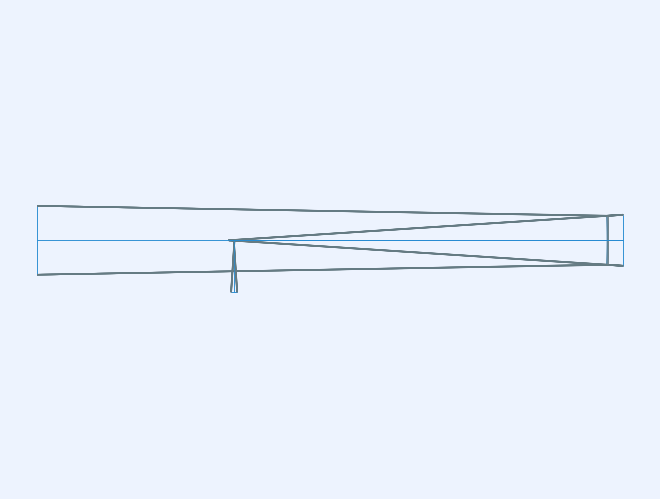

In [35]:
## Plot and display
# This uses QT you will need to have qt installed if in a notebook
# you will need to run in python directly for interactive window 
# functions (pan, zoom, save imge, etc).
fig = plt.figure(FigureClass=InteractiveLayout, opt_model=opm, 
                 do_draw_rays=True, is_dark=isdark).plot() #, clip_rays=True)
plt.show()